In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import json
import pandas as pd
import traceback

sys.path.append(".") # add results folder as a python path 
from viz import *
from analyze import *

In [2]:
# Global variables and statistics
dataset = 'data207'
dataset_name = 'ResNet on CIFAR10'
num_trials =100

lookup = load_lookup_data(dataset, '../lookup')
stats = get_difficulty_stats(lookup)
#print(lookup.keys())
n_samples = 7000
total_secs =  sum(lookup.duration)
total_hours = total_secs / 3600
mean_mins = total_secs / n_samples / 60
print(" total:  {:.2f}H, mean: {:.2f}M".format(total_hours, mean_mins))
for s in stats:
    print(s)
s = stats[3]
print("Selected target threshold: {}".format(s))
print("Global optimum: {:.4f}".format(np.max(lookup['best_acc'].values)))


 total:  9229.66H, mean: 79.11M
{'difficulty': 1.0, 'error': 0.072700024000000085, 'accuracy': 0.92729997599999991}
{'difficulty': 0.5, 'error': 0.070699990000000046, 'accuracy': 0.92930000999999995}
{'difficulty': 0.1, 'error': 0.068199992000000043, 'accuracy': 0.93180000799999996}
{'difficulty': 0.05, 'error': 0.066699982000000047, 'accuracy': 0.93330001799999995}
{'difficulty': 0.01, 'error': 0.063199997000000008, 'accuracy': 0.93680000299999999}
Selected target threshold: {'difficulty': 0.05, 'error': 0.066699982000000047, 'accuracy': 0.93330001799999995}
Global optimum: 0.9368


In [3]:
# Read sequential optimization results
results = {}
opt_secs = 432000
postfix = ".HPO_emulator({})".format(num_trials)
s_path = "./{}/T{}S/".format(dataset, opt_secs)
basic_bo = ['GP-EI', 'GP-PI', 'GP-UCB', 
              'RF-EI', 'RF-PI', 'RF-UCB' ]
rand = ['Random']
sdivs = [ 'S-Div (hybrid)' ]
ada = ['GP-Hedge']

results['Random'] = load_json(s_path + 'RANDOM-RANDOM' + postfix + '.json')

for opt in basic_bo:
    results[opt] = load_json(s_path + opt + postfix + '.json')

results['S-Div'] = load_json(s_path + 'DIV-SEQ-pure' + postfix + '.json')
results['S-Div (log)'] = load_json(s_path + 'DIV-SEQ-log' + postfix + '.json')
results['S-Div (hybrid)'] = load_json(s_path + 'DIV-SEQ-hybrid' + postfix + '.json')
results['R-Div (hybrid)'] = load_json(s_path + 'DIV-RANDOM-hybrid' + postfix + '.json')
results['GP-Hedge'] = load_json(s_path + 'DIV-BO-HEDGE-hedge3' + postfix + '.json')

<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

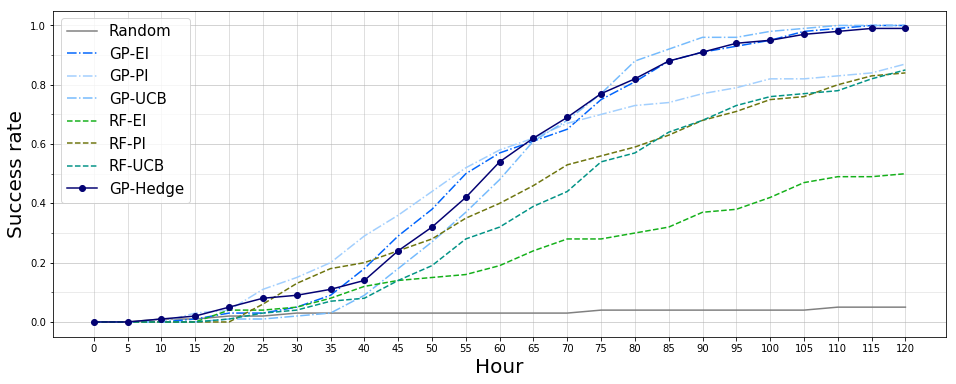

In [4]:
draw_success_rate_fig(results, s['accuracy'], 24*5 +1, step_size=5,
                                              x_unit='Hour',  indi=rand+basic_bo,  ada=['GP-Hedge'], width=16, height=6 )

<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

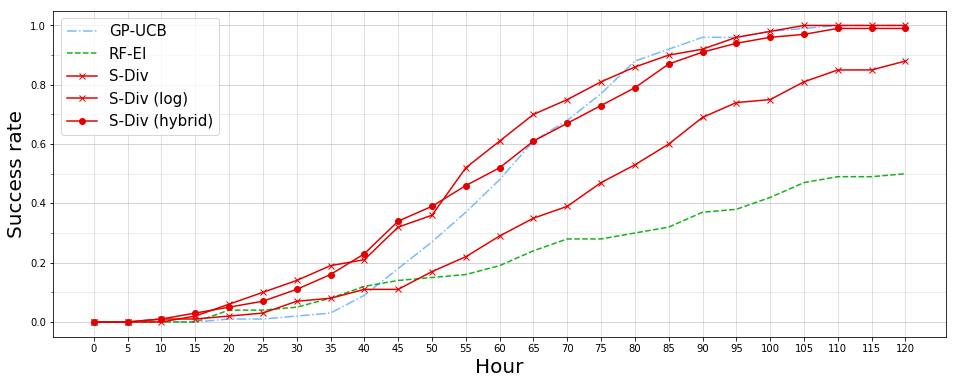

In [5]:
divs = ['S-Div', 'S-Div (log)', 'S-Div (hybrid)']
draw_success_rate_fig(results, s['accuracy'], 24*5 +1, 
                                              x_unit='Hour', step_size=5,
                                               indi=['GP-UCB', 'RF-EI'],  div=divs, 
                                                  width=16, height=6, num_runs=num_trials )

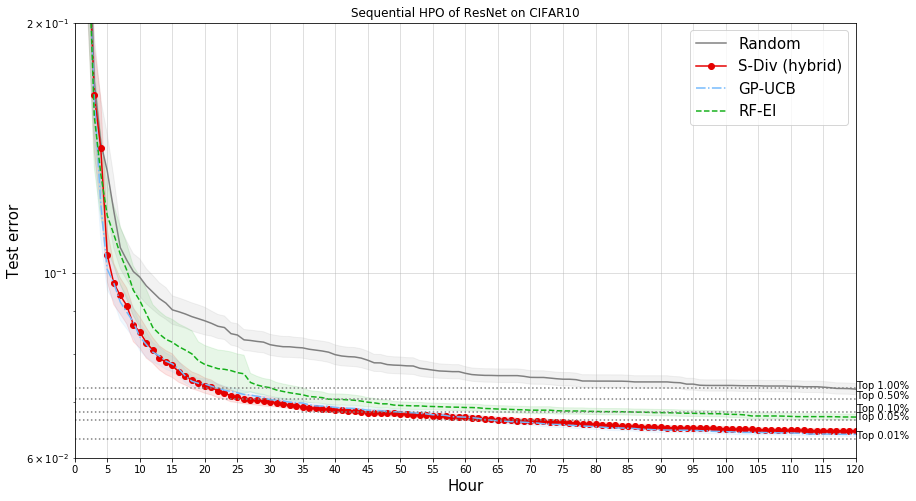

In [6]:
selected = rand + sdivs + ['GP-UCB', 'RF-EI']
draw_best_error_curve(results, selected, 100, 
                      ylim=(.06, 0.2), xlim=(0, 120), summary=True, guidelines=stats, x_steps=5, 
                      title="Sequential HPO of {}".format(dataset_name))

<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

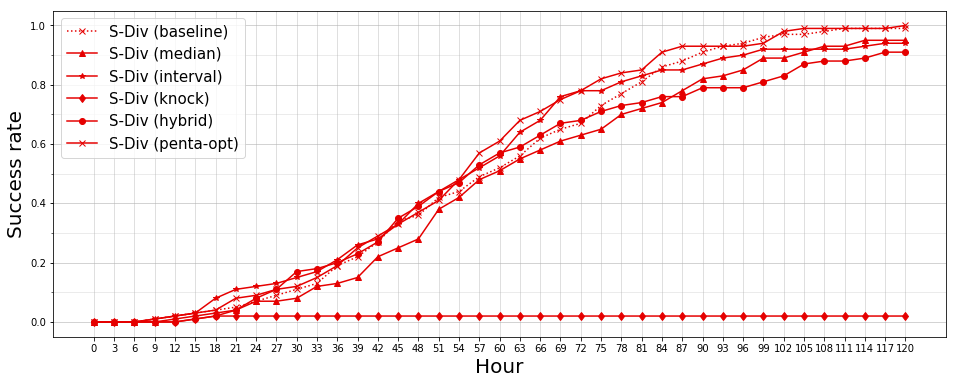

In [32]:
# ETR performance comparision
etr_divs = ['S-Div (baseline)', 'S-Div (median)', 'S-Div (interval)', 'S-Div (knock)', 'S-Div (hybrid)', 'S-Div (penta-opt)']
results['S-Div (baseline)'] = load_json(s_path + 'DIV-SEQ-hybrid.HPO_emulator(100).json')
results['S-Div (median)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-VizMedian(100).json')
results['S-Div (interval)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-Interval(100).json')
results['S-Div (knock)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-Knock(100).json')
results['S-Div (penta-opt)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-VizPentaOpt(100).json')
results['S-Div (hybrid)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-IntervalPentaOpt(100).json')
draw_success_rate_fig(results, target_goal =s['accuracy'], x_max=24*5 +1, x_unit='Hour', step_size=3, 
                            div= etr_divs, width=16, height=6 )

Target goal: 0.5%


<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

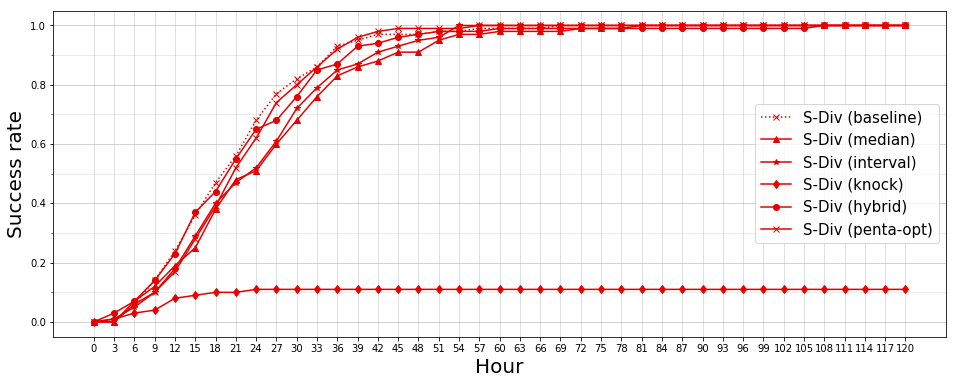

In [33]:
print("Target goal: {}%".format(stats[1]['difficulty']))
draw_success_rate_fig(results, target_goal =stats[1]['accuracy'], x_max=24*5 +1, x_unit='Hour', step_size=3, 
                            div= etr_divs, width=16, height=6 )

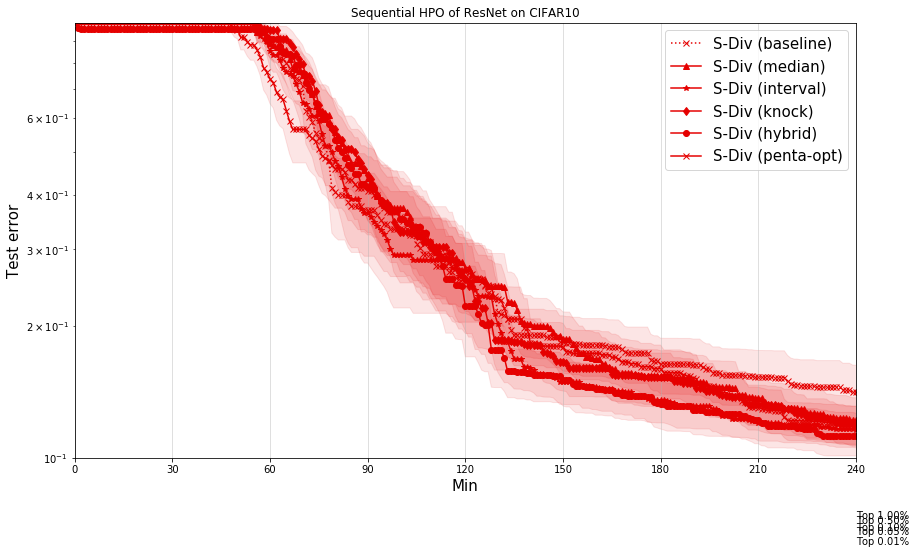

In [37]:
selected = etr_divs
draw_best_error_curve(results, selected, 100, 
                      ylim=(.1, .99), xlim=(0, 4*60), summary=True, guidelines=stats, x_steps=30, x_unit='Min', 
                      title="Sequential HPO of {}".format(dataset_name))

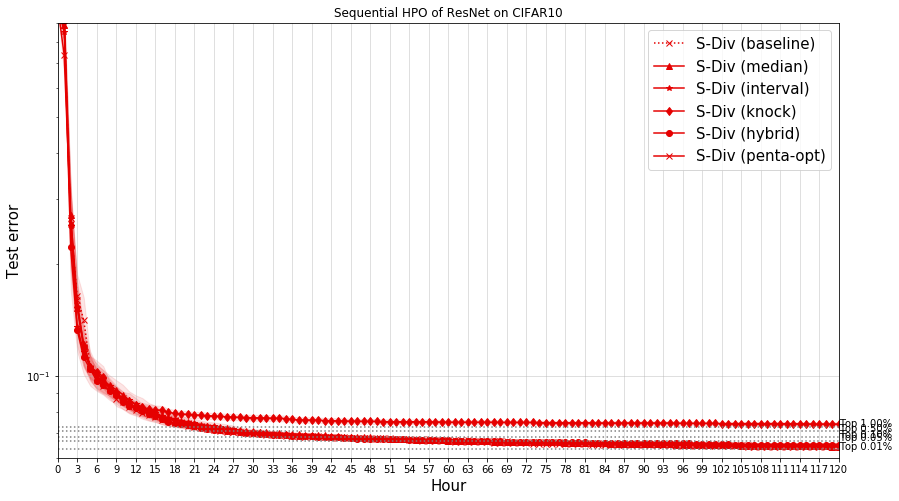

In [38]:
draw_best_error_curve(results, selected, 100, 
                      ylim=(.06, .9), xlim=(0, 24*5), summary=True, guidelines=stats, x_steps=3, x_unit='Hour', 
                      title="Sequential HPO of {}".format(dataset_name))

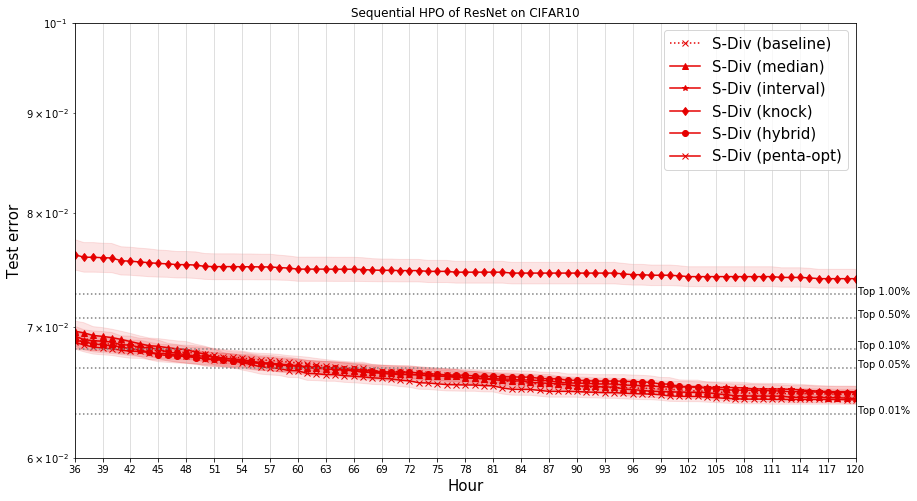

In [39]:
draw_best_error_curve(results, selected, 100, 
                      ylim=(.06, .1), xlim=(36, 120), summary=True, guidelines=stats, x_steps=3, x_unit='Hour', 
                      title="Sequential HPO of {}".format(dataset_name))

In [12]:
# Read parallel optimization results ( 6 processors)
results_6 = {}
size = 6
opt_secs = 72000
postfix = "({})".format(num_trials)
p_path = "./{}/T{}S/".format(dataset, opt_secs)
results_6['Synch. GP-EI-MCMC(10)'] = load_json(p_path + 'SYNC-BATCH.M6.None.None.6GP-EI' + postfix + '.json')
results_6['GP-EI-MCMC(10)'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.6GP-EI' + postfix + '.json')
results_6['GP-EI-MCMC(1)'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.6GP-EI-no_mcmc' + postfix + '.json')
results_6['RF-EI'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.6RF-EI' + postfix + '.json')
results_6['P-Div (in-progress)'] = load_json(p_path + 'ASYNC-BATCH.M6.premature.None.hybrid' + postfix + '.json')
results_6['P-Div'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.no_failover' + postfix + '.json')

<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

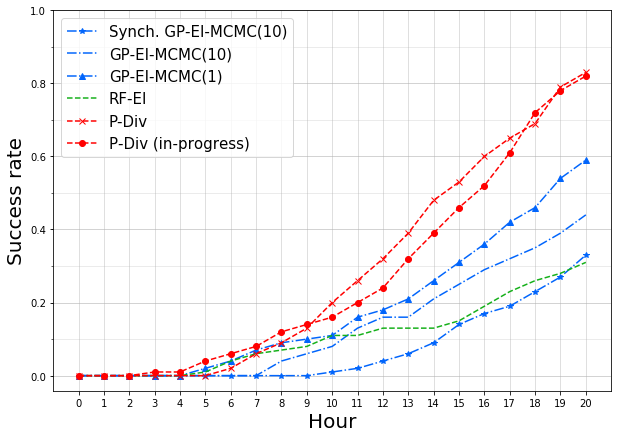

In [13]:
def restyle(name):
    marker = ''
    color ='black'
    line_style = '--'
    if 'GP-EI' in name:
        line_style = '-.'
        color = 'xkcd:bright blue'
    elif 'RF-EI' in name:
        color = 'xkcd:green'
    elif '-Div' in name:
        color = 'red'        
    if 'P-Div' == name:
        marker = 'x'
    elif 'P-Div (in-progress)' == name:
        marker = 'o'
    elif 'MCMC(1)' in name:
        marker = '^' 
    elif 'Synch.' in name:
        marker = '*'
    return marker, color, line_style

parallels = ['Synch. GP-EI-MCMC(10)', 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div', 'P-Div (in-progress)']
p_g = []
for p in parallels:
    p_g.append({"opt": p})
    
draw_success_rate_fig(results_6, s['accuracy'], 21, 
                                              x_unit='Hour', step_size=1, style_format=restyle, 
                                               parallel=p_g, width=10, height=7,  num_runs=num_trials )

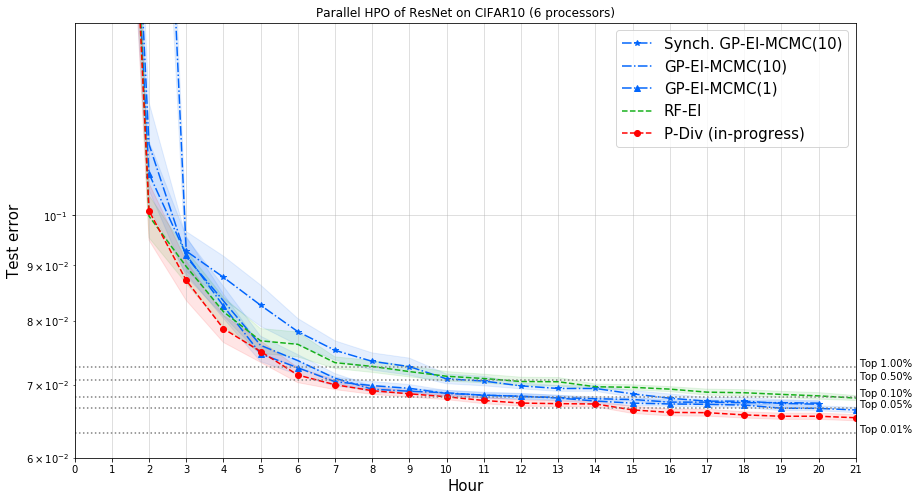

In [14]:
selected = ['Synch. GP-EI-MCMC(10)', 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div (in-progress)']

n_p = 6
num_trials = 100
flat_results_6 = {'Synch. GP-EI-MCMC(10)': results_6['Synch. GP-EI-MCMC(10)']}

for opt_name in [ 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div (in-progress)']:
    sr_r = flatten_results(n_p, results_6, opt_name, num_trials)
    flat_results_6[opt_name] = sr_r

draw_best_error_curve(flat_results_6, selected, 21, 
                      ylim=(.06, 0.15), xlim=(0, 21), summary=True, guidelines=stats, x_steps=1, style_format=restyle,
                      title="Parallel HPO of {} (6 processors)".format(dataset_name))

In [15]:
# For sequential HPO performance table generation
summary = []
checking_hours = [30, 60, 90] # 1, 2, 6, 12
fail_summary = calc_catastrophic_failures(results, s['accuracy'], num_trials, 120)
for key in fail_summary.keys():
    r = {'optimizer':  key }
    #print("{} failure rates: {}".format(key,len( fail_summary[key])))
    for h in checking_hours:
        #print('after {} hours: {:.0f}%'.format(h, fail_summary[key][h] * 100))
        r['{:2d}h'.format(h)] = (1.0 - fail_summary[key][h]) * 100
    summary.append(r)
    
table1 = pd.DataFrame(summary)
table1

,30h,60h,90h,optimizer
0,5.0,57.0,91.0,GP-EI
1,9.0,54.0,91.0,GP-Hedge
2,15.0,58.0,77.0,GP-PI
3,2.0,48.0,96.0,GP-UCB
4,10.0,52.0,90.0,R-Div (hybrid)
5,5.0,19.0,37.0,RF-EI
6,13.0,40.0,68.0,RF-PI
7,4.0,32.0,68.0,RF-UCB
8,3.0,3.0,4.0,Random
9,7.0,29.0,69.0,S-Div


In [16]:
# For parallel HPO performance table generation
summary = []
checking_hours = [10, 15, 20] # 1, 2, 6, 12
fail_summary = calc_catastrophic_failures(results_6, s['accuracy'], num_trials, 120)
for key in fail_summary.keys():
    r = {'optimizer':  key }
    #print("{} failure rates: {}".format(key,len( fail_summary[key])))
    for h in checking_hours:
        #print('after {} hours: {:.0f}%'.format(h, fail_summary[key][h] * 100))
        r['{:2d}h'.format(h)] = (1.0 - fail_summary[key][h]) * 100
    summary.append(r)
    
table = pd.DataFrame(summary)
table

,10h,15h,20h,optimizer
0,11.0,31.0,59.0,GP-EI-MCMC(1)
1,8.0,25.0,44.0,GP-EI-MCMC(10)
2,20.0,53.0,83.0,P-Div
3,16.0,46.0,82.0,P-Div (in-progress)
4,11.0,15.0,31.0,RF-EI
5,1.0,14.0,33.0,Synch. GP-EI-MCMC(10)


In [17]:
# Time to success performance table generation
summary2 = []
all_results = {}
all_results.update(results)
all_results.update(results_6)
times = calc_time_to_achieve(all_results, s['accuracy'], num_trials)
for k in times.keys():
        r = times[k]
        ri = {'1_optimizer': k}
        ri['2_mean'] = r['mean']
        ri['3_sd'] = r['sd']
        summary2.append(ri)
    #print("{}: mean {:.2f}, stdev: {:.2f}".format(k, r['mean'], r['sd']))
table2 = pd.DataFrame(summary2)
table2

,1_optimizer,2_mean,3_sd
0,GP-EI,59.553172,21.171358
1,GP-EI-MCMC(1),16.876746,4.920218
2,GP-EI-MCMC(10),17.906819,4.374067
3,GP-Hedge,59.955762,22.031706
4,GP-PI,62.517948,32.897951
5,GP-UCB,61.308600,16.669332
6,P-Div,14.543926,4.673451
7,P-Div (in-progress),14.959228,4.840147
8,R-Div (hybrid),58.771300,24.218322
9,RF-EI,18.579223,4.597860
